In [2]:
import re
import csv
import pickle
import time
import pprint
from collections import Counter
from datetime import datetime, timedelta
from urllib.request import urlopen

from bs4 import BeautifulSoup  

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from textblob import TextBlob

import spacy
# only run line 21 if language model has not been pre-installed
# !python -m spacy download en_core_web_lg
spacy_nlp = spacy.load('en_core_web_md')
from spacy import displacy
from spacy.lang.en.stop_words import STOP_WORDS
spacy.prefer_gpu()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tag.perceptron import PerceptronTagger
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

from dictionaries import lexicon, negate 
# line 35 imports our proprietary sentiment algorithm
from sentiment_algos import proprietary_sentiment_normalised

from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/marceldietsch/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
f = open('data/FOMC_cleaned.pkl', 'rb')
df = pickle.load(f)
f.close()

In [4]:
df.head()

,statements
1994-02-04,Chairman Alan Greenspan announced today that t...
1994-03-22,Chairman Alan Greenspan announced today that t...
1994-04-18,Chairman Alan Greenspan announced today that t...
1994-05-17,The Federal Reserve today announced two action...
1994-08-16,The Federal Reserve announced today the follow...


In [5]:
%%time

df['spacy_tokens'] = df['statements'].apply(spacy_nlp)


def spacy_lemma_stopwords(text):
    """remove stopwords and lemmatise all spacy tokens"""
    return [token.lemma_ for token in text if not token.is_stop]

spacy_process = lambda x: spacy_lemma_stopwords(x)
df["spacy_processed"] = df.spacy_tokens.apply(spacy_process)


def spacy_to_string(text):
    """convert lemmatised Spacy tokens back to string"""
    return ' '.join(text)


spacy_to_str = lambda x: spacy_to_string(x)
df["spacy_string"] = df.spacy_processed.apply(spacy_to_str)

# Apply sentiment algorithms

TB = lambda x: round(TextBlob(x).sentiment.polarity, 3)
NLTK = lambda x: round(sia.polarity_scores(x)['compound'], 3)
MD_proprietary = lambda x: round(proprietary_sentiment_normalised(lexicon, x), 3)

df['TextBlob_spacy'] = df.spacy_string.apply(TB)
df['NLTK_spacy'] = df.spacy_string.apply(NLTK)
df['Proprietary_spacy'] = df.spacy_string.apply(MD_proprietary)

df.head()

CPU times: user 10.7 s, sys: 742 ms, total: 11.4 s
Wall time: 11.5 s


,statements,spacy_tokens,spacy_processed,spacy_string,TextBlob_spacy,NLTK_spacy,Proprietary_spacy
1994-02-04,Chairman Alan Greenspan announced today that t...,"(Chairman, Alan, Greenspan, announced, today, ...","[Chairman, Alan, Greenspan, announce, today, F...",Chairman Alan Greenspan announce today Federal...,0.010,0.172,0.5
1994-03-22,Chairman Alan Greenspan announced today that t...,"(Chairman, Alan, Greenspan, announced, today, ...","[Chairman, Alan, Greenspan, announce, today, F...",Chairman Alan Greenspan announce today Federal...,-0.063,0.689,1.0
1994-04-18,Chairman Alan Greenspan announced today that t...,"(Chairman, Alan, Greenspan, announced, today, ...","[Chairman, Alan, Greenspan, announce, today, F...",Chairman Alan Greenspan announce today Federal...,-0.079,0.689,1.0
1994-05-17,The Federal Reserve today announced two action...,"(The, Federal, Reserve, today, announced, two,...","[Federal, Reserve, today, announce, action, de...",Federal Reserve today announce action design m...,0.170,0.963,1.0
1994-08-16,The Federal Reserve announced today the follow...,"(The, Federal, Reserve, announced, today, the,...","[Federal, Reserve, announce, today, follow, mo...",Federal Reserve announce today follow monetary...,0.150,0.848,1.0


In [195]:
period2 = df.iloc[50:125]

In [196]:
period = df.iloc[125:]

In [197]:
period.index = period.index.strftime('%m/%y')
period2.index = period2.index.strftime('%m/%y')

In [190]:
df.iloc[50:80]

,statements,spacy_tokens,spacy_processed,spacy_string,TextBlob_spacy,NLTK_spacy,Proprietary_spacy
2003-06-25,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.057,0.920,0.333
2003-08-12,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.038,0.318,0.143
2003-09-16,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.045,-0.128,0.000
2003-10-28,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.045,0.318,0.250
2003-12-09,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.080,0.823,0.250
2004-01-28,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.082,0.827,0.250
2004-03-16,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.040,0.382,-0.200
2004-05-04,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.074,0.772,1.000
2004-06-30,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.056,0.944,1.000
2004-08-10,The Federal Open Market Committee decided to...,"( , The, Federal, Open, Market, Committee, de...","[ , Federal, Open, Market, Committee, decide,...",Federal Open Market Committee decide today ...,0.079,0.969,0.778


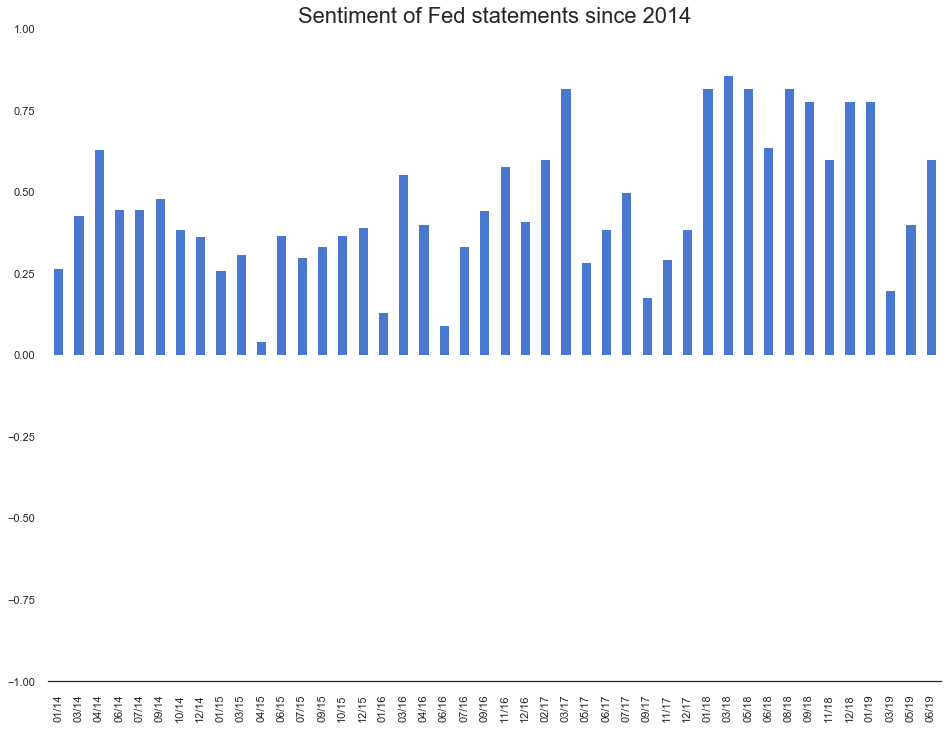

In [176]:
sns.set(style="white", palette="muted", color_codes=True)

#x = period.date

ax = period.Proprietary_spacy.plot.bar(figsize=(16, 12), color='b')
#plt.locator_params(axis=period.index, nbins=200, tight=True)
#ax.locator_params(nbins=4)
plt.ylim([-1, 1])
sns.despine(left=True, right=True)
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("Sentiment of Fed statements since 2014", fontsize=22)
plt.show()




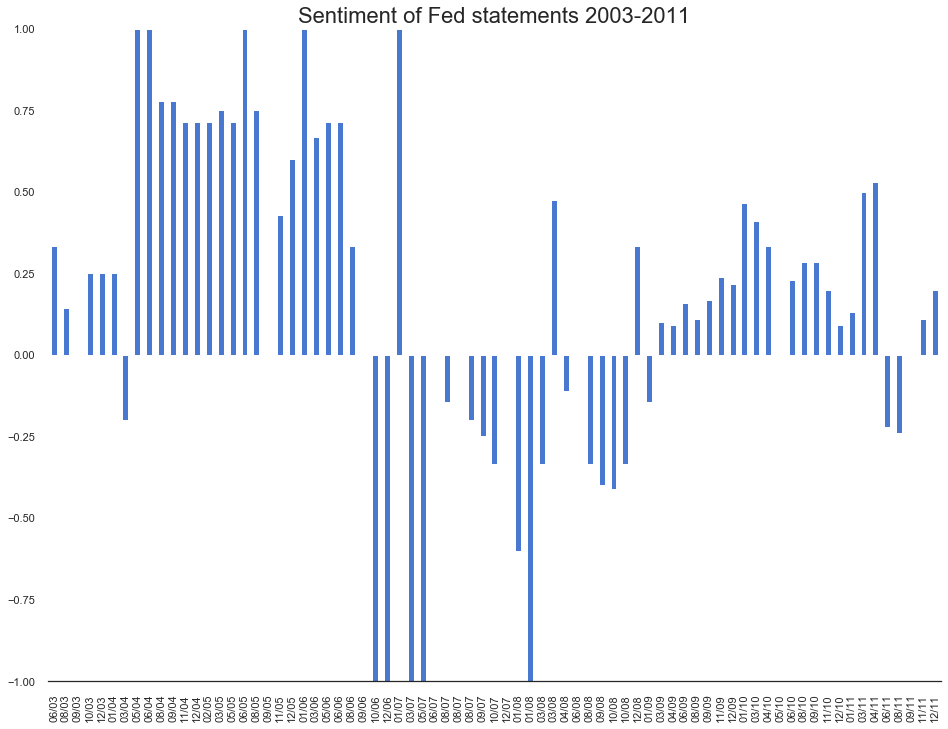

In [199]:
sns.set(style="white", palette="muted", color_codes=True)

#x = period.date

ax = period2.Proprietary_spacy.plot.bar(figsize=(16, 12), color='b')
#plt.locator_params(axis=period.index, nbins=200, tight=True)
#ax.locator_params(nbins=4)
plt.ylim([-1, 1])
sns.despine(left=True, right=True)
#ax.set_xticklabels(ax.get_xticklabels(), fontsize=14)
plt.title("Sentiment of Fed statements 2003-2011", fontsize=22)
plt.show()




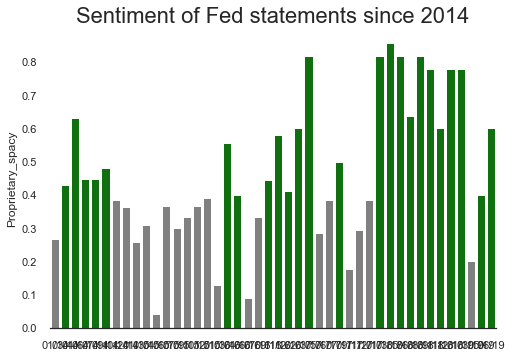

In [174]:
sns.set(style="white", palette="muted")

values = period.Proprietary_spacy   
idx = period.index 
#clrs = [if x > 0'green' if x > 0 if 'red' for x < 0 in values]

clrs = ['red' if (x<=-0.33) else 'green' if (x>=0.4) else 'grey' for x in values ]

sns.barplot(x=idx, y=values, palette=clrs) # color=clrs)





sns.despine(left=True, right=True)
plt.title("Sentiment of Fed statements since 2014", fontsize=22)
plt.show()




ValueError: Index contains duplicate entries, cannot reshape

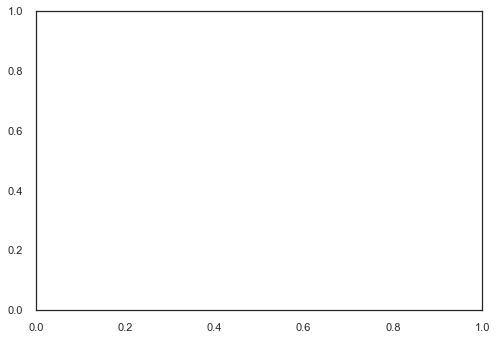

In [123]:
sns.tsplot(data = period.Proprietary_spacy, time = period.index)

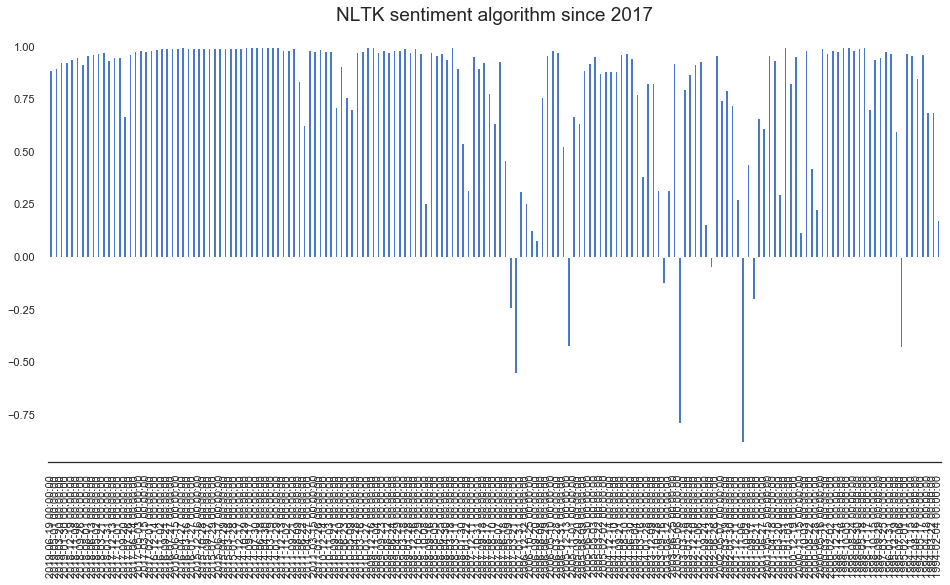

In [86]:
ax = df.NLTK_spacy.plot.bar(figsize=(16, 8), color='b')
ax.invert_xaxis()
plt.title("NLTK sentiment algorithm since 2017", fontsize=19)
sns.despine(left=True)

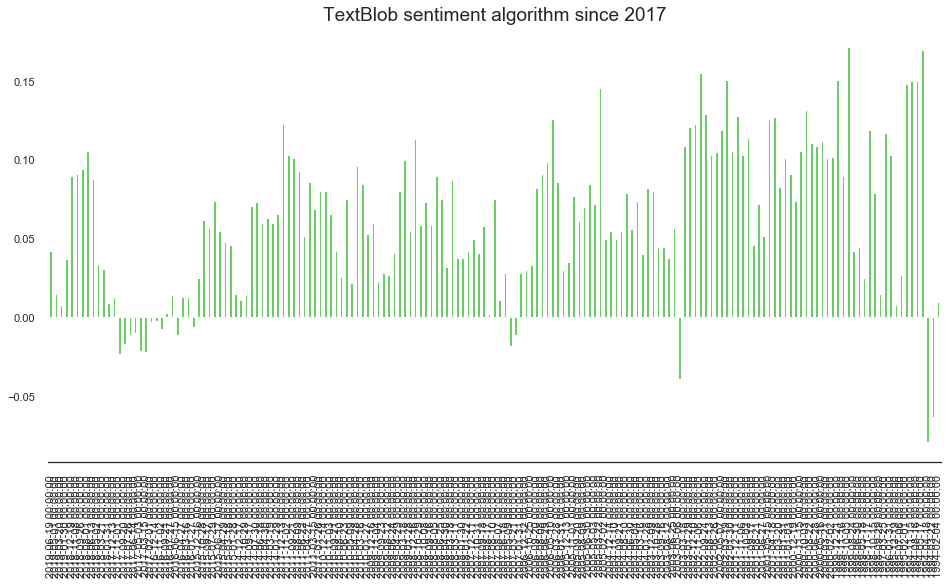

In [9]:
ax = df.TextBlob_spacy.plot.bar(figsize=(16, 8), color='g')
ax.invert_xaxis()
plt.title("TextBlob sentiment algorithm since 2017", fontsize=19)
sns.despine(left=True)